In [1]:
from SPARQLWrapper import SPARQLWrapper
from jsonpath_ng import jsonpath
import pandas as pd
from io import BytesIO
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt

# Querying the Knowledge Graph

Extracting information to build graphics from the KG. 


### Configure the access to the KG enpoint
The wrapper is defined with the endpoint URL, and a set of prefixes used in the KG is provided to shorten the queries. Two functions are defined, to execute the query and retrieve the results as a formatted table (`run_query_csv`) and as a json file (`run_query_json`). 

In [4]:
sparql = SPARQLWrapper(
    "https://solarchem.linkeddata.es/repositories/solarchem"
)

prefixes = """
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX solar: <https://w3id.org/solar/o/core#>
PREFIX solarec: <https://w3id.org/solar/o/ec#>
PREFIX solarpec: <https://w3id.org/solar/o/pec#>
PREFIX solarpc: <https://w3id.org/solar/o/pc#>
PREFIX schema: <https://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX chebi: <http://purl.obolibrary.org/obo/CHEBI_> 
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX qudt: <http://qudt.org/2.1/schema/qudt/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX iao: <http://purl.obolibrary.org/obo/IAO_> 
PREFIX obi: <http://purl.obolibrary.org/obo/OBI_> 
PREFIX unit: <http://qudt.org/vocab/unit/>

"""

def run_query_csv(query):
    sparql.setReturnFormat('csv')
    sparql.setQuery(query)
    try:
        results = sparql.queryAndConvert()
        #decode_results= results.decode(encoding='utf-8', errors='strict')
        df = pd.read_csv(BytesIO(results), sep=",")
        #display(HTML(df.to_html()))
        return(df)
    except Exception as e:
        print(e)

def run_query_json(query):
    sparql.setReturnFormat('json')
    sparql.setQuery(query)
    try:
        results = sparql.queryAndConvert()
        return(results)
    except Exception as e:
        print(e)

## Number of publications per year

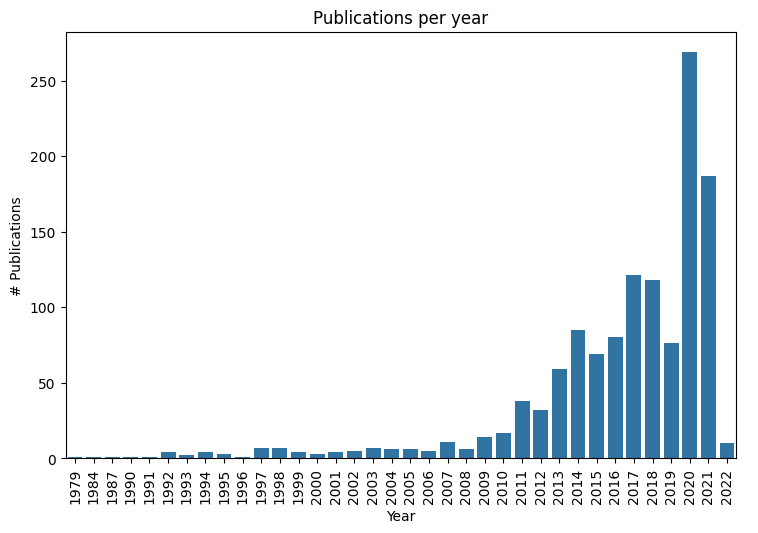

In [31]:
query = prefixes + """
    SELECT ?year (COUNT (DISTINCT ?article) AS ?numberArticles)
    WHERE {
        ?article a schema:ScholarlyArticle ;
            schema:datePublished ?year 
    } GROUP BY ?year
    ORDER BY DESC (?year)
"""
q_res = run_query_csv(query)

g_year = sns.catplot(data=q_res, x='year', y='numberArticles',
                     kind='bar', height=5, aspect=1.5)#, palette='turbo_r')
g_year.tick_params('x', labelsize=10, labelrotation=90)
g_year.set_axis_labels(x_var='Year', y_var='# Publications')
g_year.despine(top=False, right=False)
g_year.set(title='Publications per year')
g_year.savefig('figures/papers-years.png')

## Production of CO2 with TiO2 as catalyst

/var/folders/fz/wjp70mnn3ndbc_fz0gnp9n2m0000gq/T/ipykernel_37195/2625598919.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


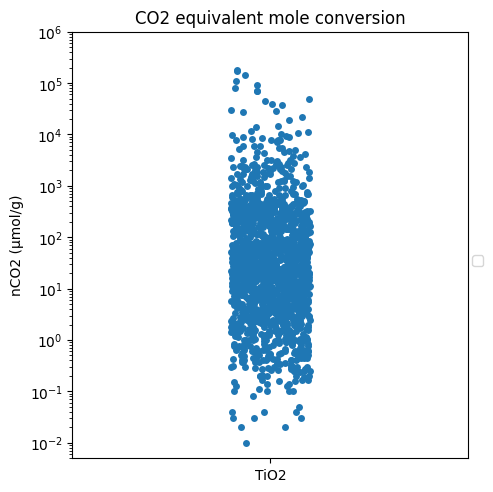

In [27]:
query = prefixes + """
    SELECT ?cat_label ?nCO2
    WHERE {
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        ?output prov:wasGeneratedBy ?expexec ;
            rdfs:label "CO2" ;
            qudt:numericValue ?nCO2 ;
            qudt:unit unit:MicroMOL-PER-GM.
        FILTER (?nCO2 != 0.00)
        FILTER (?cat_label = "TiO2")
    } 
"""
q_res = run_query_csv(query)

### takes forever with swarm
g_co2_tio2 = sns.catplot(data=q_res, x='cat_label', y='nCO2', kind='strip')
#add_quantile_reflines(g_co2_tio2, q_res['nCO2'], 0.05, 0.95)
g_co2_tio2.despine(top=False, right=False)
g_co2_tio2.set(title='CO2 equivalent mole conversion')
g_co2_tio2.set_axis_labels(x_var='', y_var='nCO2 (μmol/g)')
g_co2_tio2.set(yscale='log', ylim=(5e-3, 1e+6))
plt.legend()
sns.move_legend(g_co2_tio2.ax, loc=(1.01, 0.45))

## Production of CO2 per catalyst

     cat_label    nCO2
0         TiO2   19.50
1         TiO2   28.30
2         TiO2   31.00
3         TiO2  150.00
4         TiO2  436.50
...        ...     ...
1736      C3N4    4.56
1737      C3N4    2.60
1738      C3N4  600.00
1739      C3N4   16.70
1740      C3N4  128.40

[1741 rows x 2 columns]


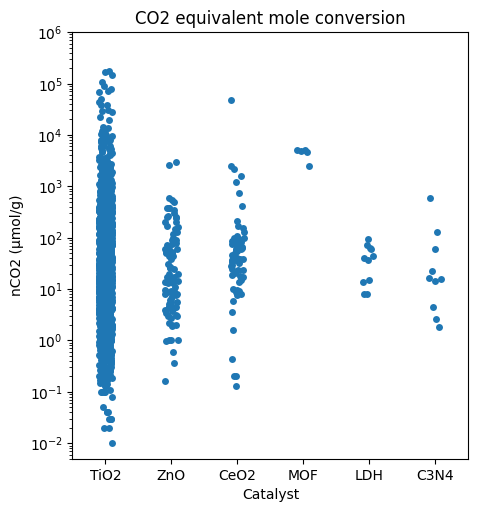

In [30]:
query = prefixes + """
    SELECT ?cat_label ?nCO2
    WHERE {
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        ?output prov:wasGeneratedBy ?expexec ;
            rdfs:label "CO2" ;
            qudt:numericValue ?nCO2 ;
            qudt:unit unit:MicroMOL-PER-GM.
        FILTER (?nCO2 != 0.00)
        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' }
    } 
"""
q_res = run_query_csv(query)
print(q_res)

### takes forever with swarm
g_co2 = sns.catplot(data=q_res, x='cat_label', y='nCO2', kind='strip')
#add_quantile_reflines(g_co2_tio2, q_res['nCO2'], 0.05, 0.95)
g_co2.despine(top=False, right=False)
g_co2.set(title='CO2 equivalent mole conversion')
g_co2.set_axis_labels(x_var='Catalyst', y_var='nCO2 (μmol/g)')
g_co2.set(yscale='log', ylim=(5e-3, 1e+6))
#plt.legend()
#sns.move_legend(g_co2_tio2.ax, loc=(1.01, 0.45))
g_co2.savefig('figures/co2-conversion.png')

## CO2 production vs catalyst mass

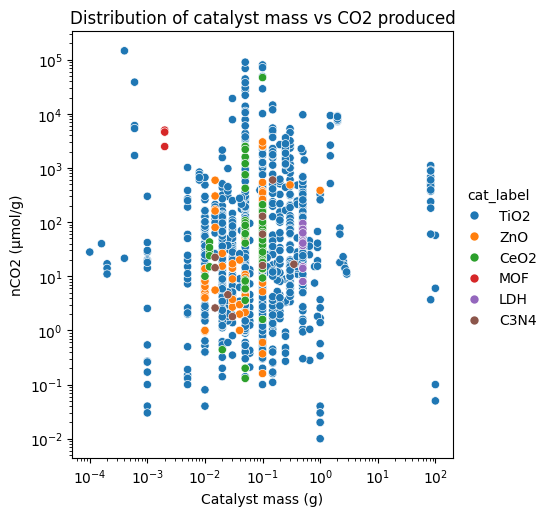

In [18]:
query = prefixes + """
    SELECT ?cat_label ?mass_cat ?nCO2
    WHERE {
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label ;
            qudt:numericValue ?mass_cat .
        ?output prov:wasGeneratedBy ?expexec ;
            rdfs:label "CO2" ;
            qudt:numericValue ?nCO2 ;
            qudt:unit unit:MicroMOL-PER-GM.
        FILTER (?nCO2 != 0.00)
        FILTER (?mass_cat != 0.00)
        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' }
    } 
"""
q_res = run_query_csv(query)
#print(q_res)

g_co2_mass = sns.relplot(data=q_res, x='mass_cat', y='nCO2', hue='cat_label')
#add_quantile_reflines(g_co2_mass, df_f['nCO2'], 0.05, 0.95)
g_co2_mass.set(xscale='log', yscale='log')
g_co2_mass.despine(top=False, right=False)
g_co2_mass.set(title='Distribution of catalyst mass vs CO2 produced')
g_co2_mass.set_axis_labels(x_var='Catalyst mass (g)', y_var='nCO2 (μmol/g)')
g_co2_mass.savefig('figures/catalyst-vs-co2.png')


## Types of catalysts vs publication date

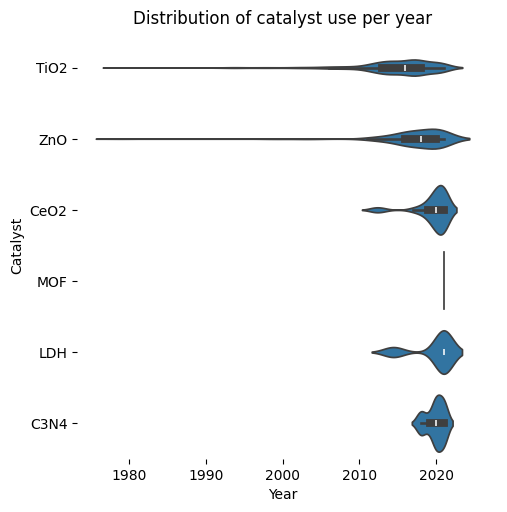

In [9]:
query = prefixes + """
    SELECT ?year ?cat_label
    WHERE {
        ?article a schema:ScholarlyArticle ;
            schema:datePublished ?year ;
            solar:hasExperimentExecution ?expexec .
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' }
    } 
"""

q_res = run_query_csv(query)

g = sns.catplot(data=q_res, x='year', y='cat_label', kind='violin')
g.set(title='Distribution of catalyst use per year')
g.set_axis_labels(x_var='Year', y_var='Catalyst')
g.despine(left=True, bottom=True)

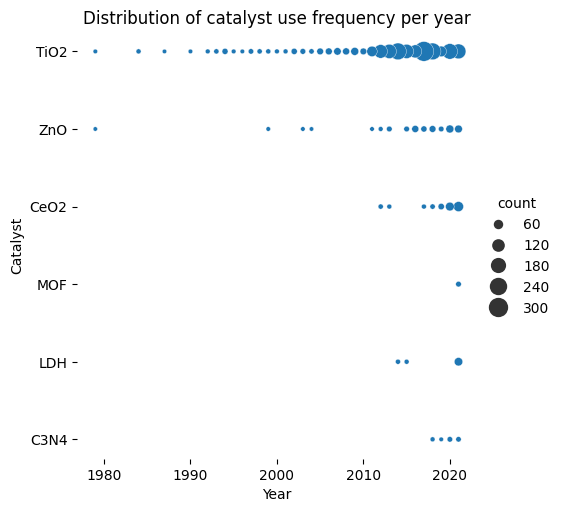

In [19]:
query = prefixes + """
    SELECT ?year (COUNT (DISTINCT ?input) AS ?count) ?cat_label
    WHERE {
        ?article a schema:ScholarlyArticle ;
            schema:datePublished ?year ;
            solar:hasExperimentExecution ?expexec .
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' } 
    } GROUP BY ?year ?cat_label
    ORDER BY DESC (?year)
"""

q_res = run_query_csv(query)

g = sns.relplot(
    data=q_res,
    x="year", y="cat_label", size="count",
    #palette=cmap, 
    sizes=(10, 200),
)
g.set(title='Distribution of catalyst use frequency per year')
g.set_axis_labels(x_var='Year', y_var='Catalyst')
g.despine(left=True, bottom=True)
g.savefig('figures/catalyst-use.png')

/var/folders/fz/wjp70mnn3ndbc_fz0gnp9n2m0000gq/T/ipykernel_37195/1682718415.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=q_res,


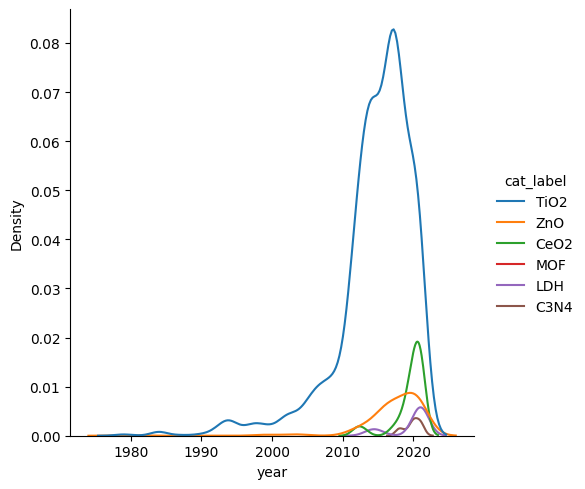

In [11]:
query = prefixes + """
    SELECT ?year ?cat_label
    WHERE {
        ?article a schema:ScholarlyArticle ;
            schema:datePublished ?year ;
            solar:hasExperimentExecution ?expexec .
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' }
    } 
"""

q_res = run_query_csv(query)

g = sns.displot(data=q_res,
                     hue='cat_label', 
                     x='year',
                     kind='kde',
                     )

## Selectivity of catalysts per product

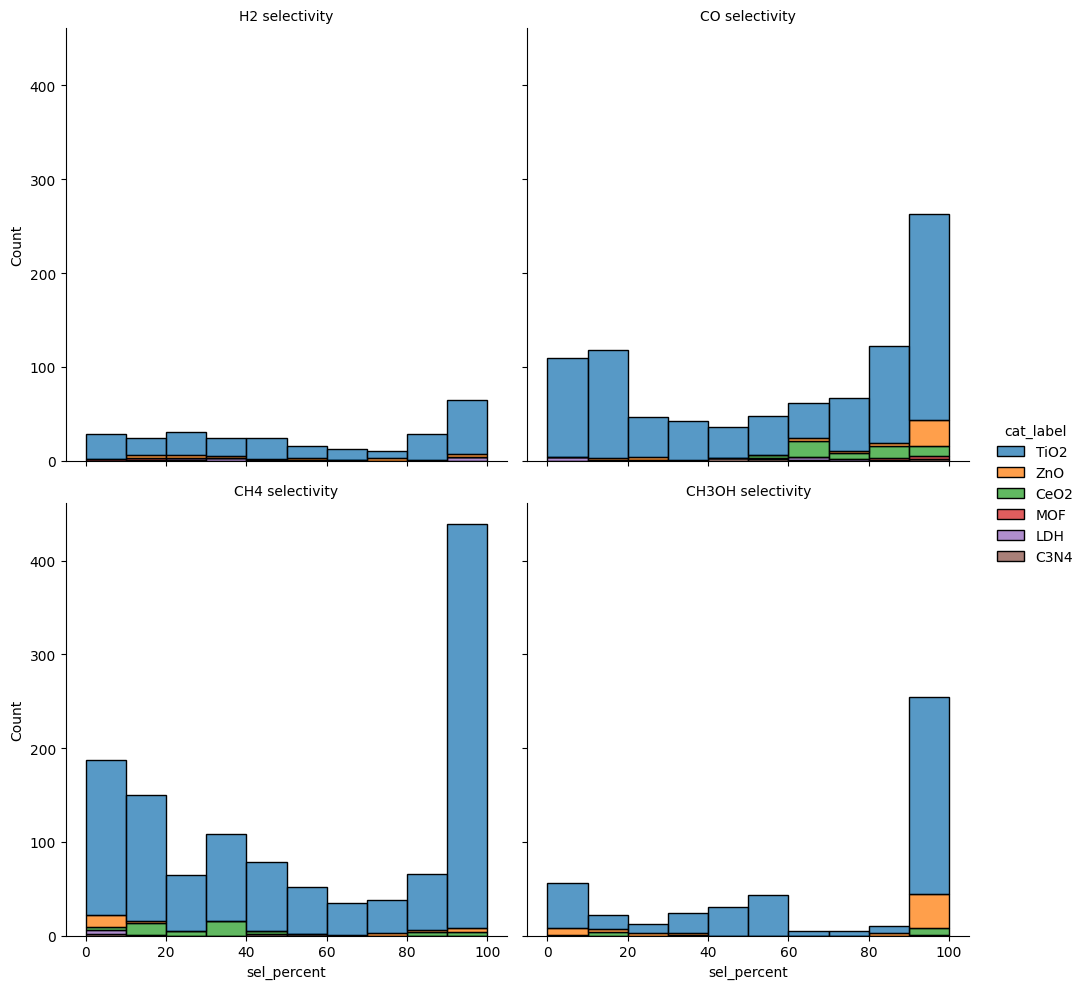

In [33]:
query = prefixes + """
    SELECT ?cat_label ?product_label ?sel_percent
    WHERE {
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        ?output prov:wasGeneratedBy ?expexec ;
            rdfs:label ?product_label ;
            solar:selectivityPercentage ?sel_percent .

        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' } 
        VALUES ?product_label { 'CO' 'H2' 'CH4' 'CH3OH' } 
    } ORDER BY DESC (?product_label)
"""

q_res = run_query_csv(query)

g_hist = sns.displot(data=q_res,
                     col='product_label', col_wrap=2,
                     hue='cat_label', multiple='stack',
                     x='sel_percent',
                     kind='hist',
                    # stat='percent',   ##already calculated in KG
                     bins=10
                     )
g_hist.set_titles(col_template='{col_name} selectivity')

/var/folders/fz/wjp70mnn3ndbc_fz0gnp9n2m0000gq/T/ipykernel_37195/507574240.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=q_res,
/var/folders/fz/wjp70mnn3ndbc_fz0gnp9n2m0000gq/T/ipykernel_37195/507574240.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.displot(data=q_res,


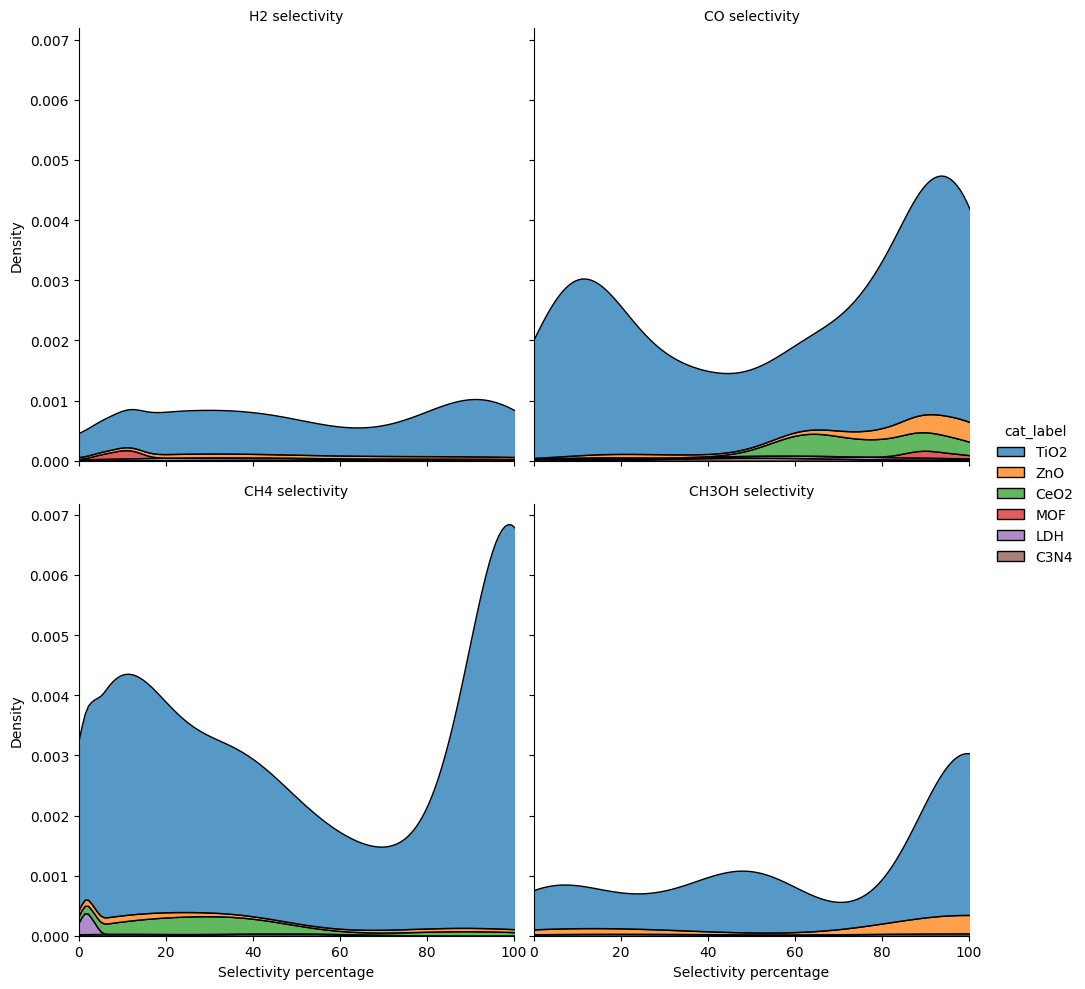

In [36]:
query = prefixes + """
    SELECT ?cat_label ?product_label ?sel_percent
    WHERE {
       ?expexec prov:used ?input .
       ?input solar:hasRole solar:Catalyst ;
            rdfs:label ?cat_label .
        ?output prov:wasGeneratedBy ?expexec ;
            rdfs:label ?product_label ;
            solar:selectivityPercentage ?sel_percent .

        VALUES ?cat_label { 'TiO2' 'ZnO' 'CeO2' 'MOF' 'LDH' 'C3N4' } 
        VALUES ?product_label { 'CO' 'H2' 'CH4' 'CH3OH' } 
    } ORDER BY DESC (?product_label)
"""

q_res = run_query_csv(query)

g = sns.displot(data=q_res,
                     col='product_label', col_wrap=2,
                     hue='cat_label', multiple='stack',
                     x='sel_percent',
                     kind='kde',
                    # stat='percent',   ##already calculated in KG
                     #bins=10
                     )
g.set(xlim=(0,100))
g.set_titles(col_template='{col_name} selectivity')
g.set_axis_labels(x_var='Selectivity percentage')
g.savefig('figures/selectivity.png')